In [2]:
import pandas as pd
import numpy as np 
import rasterio
import rioxarray
import matplotlib.pyplot as plt 
import xarray as xr
import math
import seaborn as sns
from sklearn.metrics import r2_score

class Analysis:
    def __init__(self, input, gnd_truth) -> None:
        self.inp = rioxarray.open_rasterio(input, band_as_variable=True)
        self._tmp = rioxarray.open_rasterio(gnd_truth, band_as_variable=True)
        self._gnd = self._tmp.rio.reproject_match(self.inp)
        self.gnd = self._gnd.sel(
            x=slice(self._tmp['x'].min()+0.01, self._tmp['x'].max()-0.01),
            y=slice(self._tmp['y'].min()+0.01, self._tmp['y'].max()-0.01)
            )
        self.diff = self.inp - self.gnd
        
        abdiff = abs(self.diff).band_1.to_numpy().flatten()
        diff = self.diff.band_1.to_numpy().flatten()
        
        print("min diff &", round(np.min(diff),3), "\\")
        print("max diff &", round(np.max(diff),3), "\\")
        print("median diff &", round(np.median(diff),3) , "\\")
        print("mean diff &", round(np.mean(diff),3), "\\")
        print("std &", round(np.std(diff),3), "\\")
        rmse = math.sqrt(np.mean(diff**2))
        print("rmse &", round(rmse,3))
        print("mae &", round(np.mean(abdiff),3))
    
    def tester_diff(self, tester_diff):
        out = tester_diff.sel(
            x=slice(self.gnd['x'].min()+0.03, self.gnd['x'].max()-0.03),
            y=slice(self.gnd['y'].min()+0.03, self.gnd['y'].max()-0.03)
        )
        return out

    def get_pred_h(self, results):
        self.rf_results = rioxarray.open_rasterio(results, band_as_variable=True)
        
    def set_ground_truth(self, gt_tif):
        self.ground_truth = rioxarray.open_rasterio(gt_tif, band_as_variable=True)
        self.ground_truth = self.ground_truth.sel(
        x=slice(self.input_data['x'].min()+0.0, self.input_data['x'].max()-0.0),
        y=slice(self.input_data['y'].min()+0.0, self.input_data['y'].max()-0.0)
        )
        return self.ground_truth

    def set_test_data(self, test_data_tif):
        self.test_data = rioxarray.open_rasterio(test_data_tif, band_as_variable=True)
        return self.test_data
    
    def get_difference(self):
        self.ground = self.ground_truth.rio.reproject_match(self.test_data)
        self.difference = self.test_data - self.ground
        self.absDifference = abs(self.test_data - self.ground)
    
    def calc_rmse(self):
        diff = self.test_data - self.ground
        diff_sq = diff ** 2
        mean = diff_sq.band_1.mean()
        rmse = math.sqrt(mean)
        return rmse
    
    def plot1(self):
        self.inp = self.inp.sel(
            x=slice(self.inp['x'].min()+0.0, self.inp['x'].max()-0.0),
            y=slice(self.inp['y'].min()+0.0, self.inp['y'].max()-0.0)
            )
        self.inp.band_1.plot(cmap='gist_earth',
                            vmin=self.inp.band_1.min(), 
                            vmax=self.inp.band_1.max())
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'Laplace Interpolation')
        plt.tight_layout()
        plt.tick_params(axis='x', rotation=90)
        
    def plot2(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        self.inp = self.inp.sel(
            x=slice(self.gnd['x'].min()+0.0, self.gnd['x'].max()-0.0),
            y=slice(self.gnd['y'].min()+0.0, self.gnd['y'].max()-0.0)
            )
        self.inp.band_1.plot(cmap='gist_earth', ax=axes[0], 
                                     vmin=self.inp.band_1.min(), 
                                     vmax=self.inp.band_1.max())
        

        self.diff.band_1.plot(cmap='RdBu', ax=axes[1])
        
        for ax in axes:
            ax.tick_params(axis='x', rotation=45)
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
        
        axes[0].set_title(f'RF Interpolation')
        axes[1].set_title('Difference against Ground Truth')
    
    def cross_section(self):
        pass
    
    def plot3(self):
        sns.set_context("paper")
    
        diff = self.diff.band_1.to_numpy().flatten()
        mean = np.mean(diff)
        std_dev = np.std(diff)

        # Define a threshold to filter out values larger than 3SD from the mean
        threshold = mean + 3 * std_dev
        testerdiff1 = self.tester_diff(self.diff)
        testerdiff2 = self.tester_diff(self.inp)

        # Filter the data to exclude values larger than 3SD
        f_tester_diff = [x for x in self.test_data if x <= threshold]

        plt.hist(testerdiff1.band_1.to_numpy().flatten(), bins=110, edgecolor=None, alpha=0.4, label='Laplace Interpolation')
        plt.hist(testerdiff2.band_1.to_numpy().flatten(), bins=110, edgecolor=None, alpha=0.6, label='Random Forest')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.title('Error Distribution')
        plt.show()




In [4]:
AU_truth = '../ICESAT/tasmania/gnd_dem_02.tif'
pred = '../ICESAT/tasmania/results/tasmania__au3.tif'
res = '../ICESAT/tasmania/results/tasmania_tasman_samples4.tif'
laplace = '../ICESAT/tasmania/interpolation/interpSamples_laplace.tif'


tester = Analysis(pred, AU_truth)
ground_truth = tester.gnd
input_data = tester.inp
sns.set()

# tester.plot2()
tester.plot1()

RasterioIOError: ../ICESAT/tasmania/gnd_dem_02.tif: No such file or directory

min diff & -281.367 \
max diff & 169.54 \
median diff & -2.734 \
mean diff & -6.986 \
std & 37.905 \
rmse & 38.543
mae & 24.108


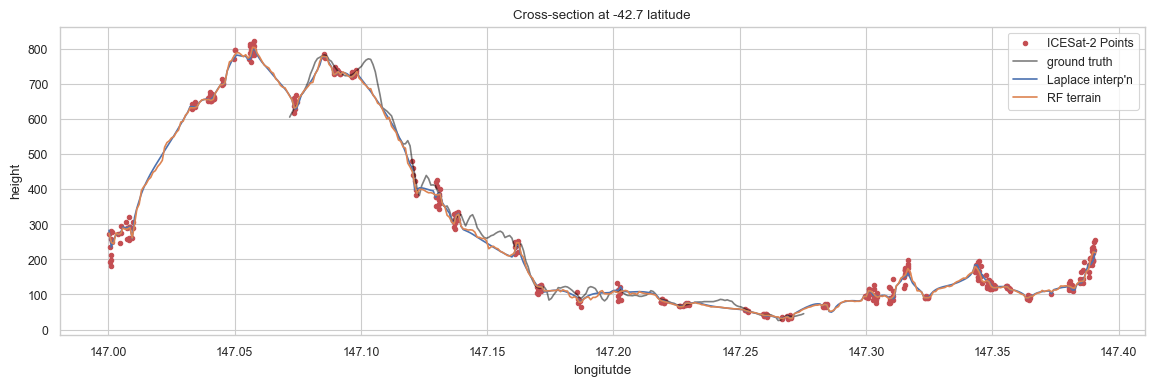

<Figure size 10200x1000 with 0 Axes>

In [103]:
taz = r"../ICESAT/tasmania/tasmania.csv"
icesat = pd.read_csv(taz)
lats = icesat['lat'][:]
lons = icesat['lon'][:]
elevations = icesat['h_te_interp'][:]
sns.set_context("paper")
sns.set_style("whitegrid")

place = Analysis(laplace, AU_truth)

target_lat = -42.70

tolerance = 0.0015 # Tolerance range (+/- 0.2 degrees)
indices = np.where((lats >= target_lat - tolerance) & (lats <= target_lat + tolerance))

# Extract data for the selected latitude range
s_lons = lons[indices[0]]
s_elev = elevations[indices[0]]

mask = ground_truth != -9999
filtered_data = ground_truth.where(mask, drop=True)

cross_section_1 = ground_truth.sel(y=target_lat, method='nearest')
cross_section_2 = input_data.sel(y=target_lat, method='nearest')
cross_section_3 = place.inp.sel(y=target_lat, method='nearest')

fig = plt.figure(figsize=(14, 4))

plt.scatter(s_lons, s_elev, s=10, c='r', label='ICESat-2 Points')
cross_section_1.band_1.plot(label="ground truth", c='black', alpha=0.5)
cross_section_3.band_1.plot(label="Laplace interp'n")
cross_section_2.band_1.plot(label="RF terrain")

plt.legend()
plt.xlabel('longitutde')
plt.ylabel('height')
plt.title(f'Cross-section at {target_lat} latitude')
plt.figure(figsize=(102, 10))
plt.show()


In [ ]:
taz = r"../ICESAT/tasmania/tasmania.csv"
icesat = pd.read_csv(taz)
lats = icesat['lat'][:]
lons = icesat['lon'][:]
elevations = icesat['h_te_interp'][:]

target_lat = -42.75
tolerance = 0.001 # Tolerance range (+/- 0.2 degrees)

indices = np.where((lats >= target_lat - tolerance) & (lats <= target_lat + tolerance))
# Extract data for the selected latitude range
s_lons = lons[indices[0]]
s_elev = elevations[indices[0]]

# tasman_dataset1.band_1.plot(label="ground truth")
mask = tasman.ground_truth != -9999
filtered_data = tasman.ground_truth.where(mask, drop=True)


# filtered_data.band_1.plot(label="ground truth")
cross_section_gnd = filtered_data.sel(y=target_lat, method='nearest')
cross_section_test = tasman_dataset1.sel(y=target_lat, method='nearest')
# cross_section_laplace = tasman_dataset2.sel(y=target_lat, method='nearest')


# icesatpoints = pd.read_csv('../ICESAT/tasmania/tasmania.csv')
# measurement_x = icesatpoints['lon'].values
# measurement_y = icesatpoints['lat'].values
# mask = np.abs(measurement_y - -42.71) <= 0.1

# target_y = -42.70
# tolerance = 0.01

# Filter the y-axis values based on the mask
# filtered_x = measurement_x[(measurement_y >= target_y - tolerance) & (measurement_y <= target_y + tolerance)]
# filtered_y = measurement_y[(measurement_y >= target_y - tolerance) & (measurement_y <= target_y + tolerance)]

plt.figure(figsize=(12, 4))
plt.scatter(s_lons, s_elev, s=10, c='r', label='ICESat-2 Points')

# plt.scatter(filtered_x, filtered_y, c='red', marker='o', label='Measurements', s=1)
cross_section_gnd.band_1.plot(label="Ground Truth")
cross_section_test.band_1.plot(label="RF Terrain")

# cross_section_laplace.band_1.plot(label="Laplace Interpolation")
plt.legend()
plt.xlabel('longitutde')
plt.ylabel('height')
plt.title(f'Cross-section at {target_lat} latitude')

plt.show()